## Worldmap

In [81]:
from pathlib import Path
import re
import pandas as pd
import country_converter as coco
import plotly.express as px
import matplotlib as mpl
import plotly.io as pio
from IPython.display import Image, display

In [82]:
# --- configuration ---
file_path = '../data/Data_extraction_general_data.xlsx'
country_col = 'Location? Where the study is based'

# outputs
out_dir = Path('./outputs').resolve()
out_dir.mkdir(parents=True, exist_ok=True)
png_path = out_dir / 'world_meta_analysis.png'
html_path = out_dir / 'world_meta_analysis.html'
csv_counts = out_dir / 'country_counts.csv'

# --- load data ---
df_path = Path(file_path).resolve()
df = pd.read_excel(df_path)

In [83]:
# --- split multi-country cells ---
split_pattern = r',|;|\+|/|\band\b'
countries = (
    df[country_col]
    .astype(str)
    .str.replace(r'\s+', ' ', regex=True).str.strip()
    .str.replace(r'\.$', '', regex=True)
    .apply(lambda x: re.split(split_pattern, x) if x else [])
)

countries_long = (
    pd.DataFrame({country_col: countries})
    .explode(country_col, ignore_index=True)
)
countries_long[country_col] = (
    countries_long[country_col].astype(str).str.strip().replace({'nan': None, '': None})
)
countries_long = countries_long.dropna(subset=[country_col])

# --- normalize to ISO3 ---
cc = coco.CountryConverter()
countries_long['iso3'] = cc.convert(
    names=countries_long[country_col].tolist(),
    to='ISO3',
    not_found=None  # None for anything not recognized
)

mask_none = countries_long['iso3'].isna()
if mask_none.any():
    countries_long.loc[mask_none, 'iso3'] = (
        countries_long.loc[mask_none, country_col].map(overrides)
    )

# --- collect unmapped raw values for inspection ---
unmapped = (
    countries_long.loc[countries_long['iso3'].isna(), country_col]
    .dropna()
    .sort_values()
    .unique()
    .tolist()
)

# --- counts per ISO3 ---
counts = (
    countries_long.dropna(subset=['iso3'])
    .value_counts('iso3')
    .rename('study_count')
    .reset_index()
)

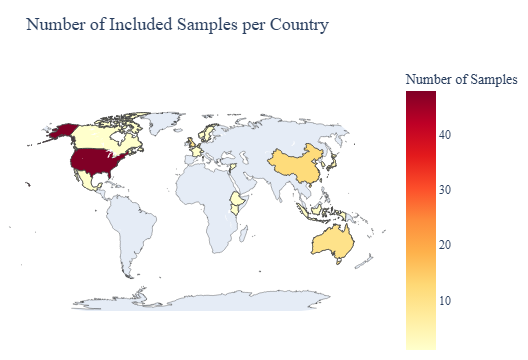

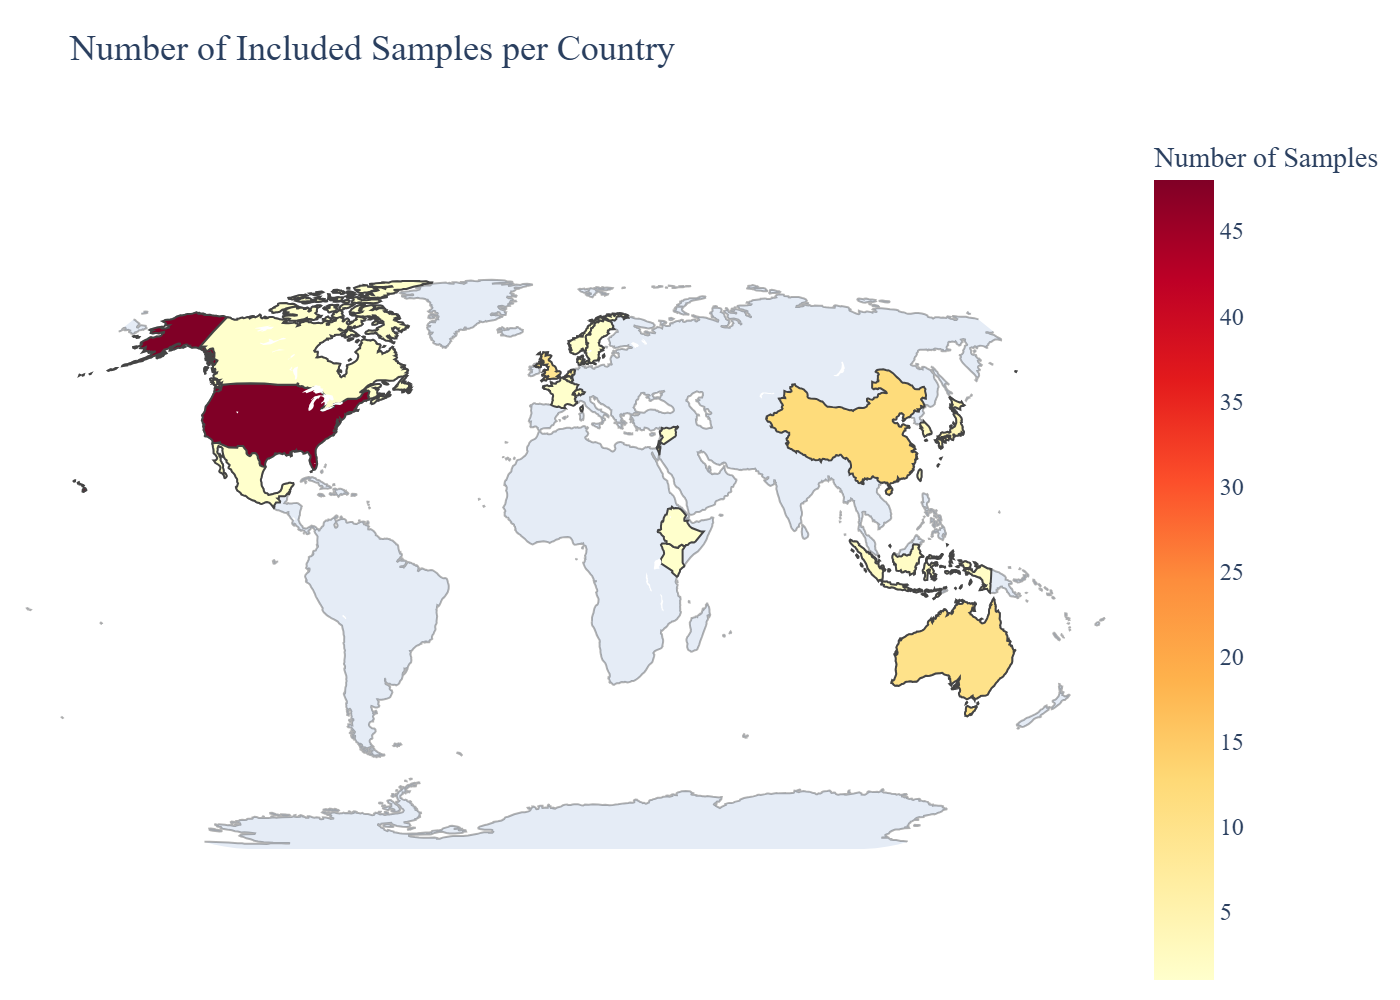

In [84]:
# --- plot ---
if counts.empty:
    print('No valid country codes found; writing empty outputs.')
    counts.to_csv(csv_counts, index=False)
else:
    fig = px.choropleth(
        counts,
        locations='iso3',
        color='study_count',
        color_continuous_scale='YlOrRd',
        projection='natural earth',
        title='Number of Included Samples per Country'
    )

    fig.update_geos(showframe=False, showcoastlines=True, coastlinecolor='rgba(0,0,0,0.3)')

    # Times New Roman + grey background
    fig.update_layout(
        margin=dict(l=0, r=0, t=60, b=0),
        font=dict(family="Times New Roman", size=14),
        title=dict(font=dict(family="Times New Roman", size=18)),
        coloraxis_colorbar=dict(
            title=dict(text="Number of Samples", font=dict(family="Times New Roman", size=14)),
            tickfont=dict(family="Times New Roman", size=12)
        ),
        plot_bgcolor="lightgrey"    # inside the plot area
    )

    # save interactive HTML + static PNG
    fig.write_html(str(html_path))
    fig.write_image(str(png_path), scale=2)

    # exports
    counts.sort_values('study_count', ascending=False).to_csv(csv_counts, index=False)
    fig.show()

png_bytes = pio.to_image(fig, format="png", scale=2)  # requires kaleido installed
display(Image(data=png_bytes))
